In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

#### Preprocessing data

In [2]:
# Load data
bc = datasets.load_breast_cancer()

# Separate Features and Labels
X, y = bc.data, bc.target

# Getting the n-dim
n_samples, n_features = X.shape
print(n_samples, n_features)


569 30


In [3]:
# Split data into training and testing sets

def split_scale_convert(x, y, test_size, random_state):
  # Split
  X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=test_size , random_state=random_state)

  # scale data 
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  #convert data
  X_train = torch.from_numpy(X_train.astype(np.float32))
  X_test = torch.from_numpy(X_test.astype(np.float32))
  y_train = torch.from_numpy(y_train.astype(np.float32))
  y_test = torch.from_numpy(y_test.astype(np.float32))

  return X_train,X_test,y_train,y_test 

In [4]:
X_train,X_test,y_train,y_test = split_scale_convert(X, y, 0.2, 1234)

In [5]:
print("Before:", y_train.shape)
y_train = y_train.view(y_train.shape[0], 1)
print("After:", y_train.shape)

Before: torch.Size([455])
After: torch.Size([455, 1])


In [6]:
print("Before:", y_test.shape)
y_test = y_test.view(y_test.shape[0], 1)
print("After:", y_test.shape)

Before: torch.Size([114])
After: torch.Size([114, 1])


####  Defining Model 

In [7]:
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_features)

#### Defining Loss and Optimizer

In [8]:
lr = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
num_epochs = 100


#### Training Loop

In [9]:
losses = []

for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    losses.append(loss)

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 10, loss = 0.4975
epoch: 20, loss = 0.4235
epoch: 30, loss = 0.3734
epoch: 40, loss = 0.3372
epoch: 50, loss = 0.3097
epoch: 60, loss = 0.2879
epoch: 70, loss = 0.2701
epoch: 80, loss = 0.2553
epoch: 90, loss = 0.2428
epoch: 100, loss = 0.2320


#### Evaluation 

In [10]:
with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')

accuracy: 0.9123


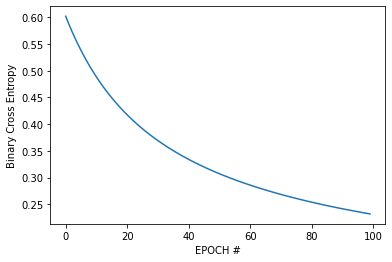

In [11]:
plt.plot(range(num_epochs),losses)
plt.ylabel('Binary Cross Entropy')
plt.xlabel('EPOCH #');

In [12]:
cm = metrics.confusion_matrix(y_test, y_predicted_cls)
print(cm)

[[38  7]
 [ 3 66]]


In [13]:
print("True positive: {}".format(cm[0][0]))
print("True negative: {}".format(cm[1][1]))
print("False positive: {}".format(cm[0][1]))
print("False negative: {}".format(cm[1][0]))

True positive: 38
True negative: 66
False positive: 7
False negative: 3


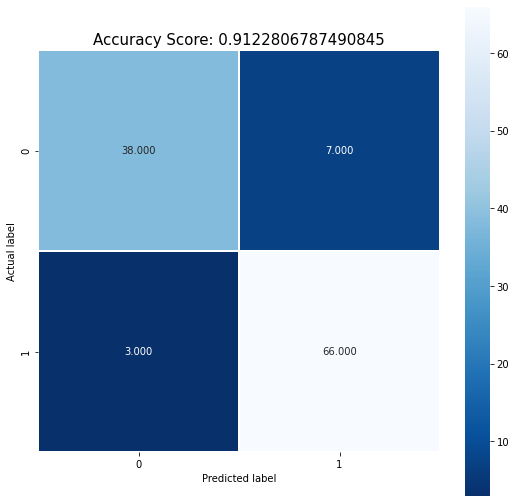

In [14]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc)
plt.title(all_sample_title, size = 15);

In [17]:
from sklearn.metrics import classification_report

target_names = ["Class 0", "Class 1"]
print(classification_report(y_test, y_predicted_cls, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.93      0.84      0.88        45
     Class 1       0.90      0.96      0.93        69

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.91      0.91      0.91       114

